# 특정한 범위의 패치의 어텐션 경향 추출
TP, TN, FP, FN 4가지 상황에서 특정한 패치의 위치를 입력으로 받고 그 패치의 어텐션 값의 경향을 그래프로 추출합니다.

14*14크기의 어텐션 맵에서 index는 가장 위쪽이 x가 0, 가장 왼쪽이 y가 0입니다.

특정 상황에 맞춰진 코드로 주의하여 사용합니다.

### Import Libraries

In [141]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob
import gc
import os
import time

from vit_rollout import VITAttentionRollout

### Definition

In [142]:
def draw_img(model, PATH_data_list, label):
    attention_list = list()
    data_number_list = list()
    for PATH_data in PATH_data_list:
        data_number = PATH_data.split('/')[-1].split('.')[0].split('\\')[-1]
        data_number_list.append(int(data_number))
        
        # Load data: using CPU
        with open(PATH_data, 'rb') as f:
            data = pickle.load(f)

        input_tensor = data['tensor']
        input_tensor = input_tensor.reshape((1,14,28,28))
        input_tensor = input_tensor.to(torch.float32).cpu()

        # Rollout attentions
        attention_rollout = VITAttentionRollout(model, head_fusion='max', discard_ratio=0.90)
        mask_law = attention_rollout(input_tensor) # (14, 14)
        attention_list.append(mask_law)

        # np.set_printoptions(precision=4, formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=np.Inf)
        # f = open("../../output/attention_logical/"+label+"_"+data_number+".txt", 'w')
        # f.write(str(mask_law))
        # f.close()

    return attention_list, data_number_list

In [143]:
def draw_img_TP(model, PATH_data_list, label):
    attention_list = list()
    data_number_list = list()
    for PATH_data in PATH_data_list:
        data_number = PATH_data.split('/')[-1].split('.')[0].split('\\')[-1]
        data_number_list.append(int(data_number))
        
        # Load data: using CPU
        with open(PATH_data, 'rb') as f:
            data = pickle.load(f)

        input_tensor = data['tensor']
        input_tensor = input_tensor.reshape((1,14,28,28))
        input_tensor = input_tensor.to(torch.float32).cpu()

        # Rollout attentions
        attention_rollout = VITAttentionRollout(model, head_fusion='max', discard_ratio=0.90)
        mask_law = attention_rollout(input_tensor) # (14, 14)
        
        # Edit attentions
        for x in range(0, 13+1): # 차선 밖
            for y in range(0, 3+1):
                mask_law[x][y] = mask_law[x][y] * 0.5
            for y in range(9, 13+1):
                mask_law[x][y] = mask_law[x][y] * 0.5
        
        for x in range(0, 13+1): # 반대편 차선 가드레일
            mask_law[x][4] = mask_law[x][4] * 0.35
        
        for x in range(0, 13+1): # 반대편 차선
            mask_law[x][5] = mask_law[x][5] * 0.5

        for x in range(8, 13+1): # Ego Vehicle 뒤
            for y in range(6, 8+1):
                mask_law[x][y] = mask_law[x][y] * 0.5

        # 특이 지점
        mask_law[6][7] = mask_law[6][7] * 0.3
        mask_law[7][6] = mask_law[7][6] * 0.3
        mask_law[8][6] = mask_law[8][6] * 0.3
        mask_law[9][6] = mask_law[9][6] * 0.3

        attention_list.append(mask_law)
        del data_number, data, input_tensor, attention_rollout, mask_law
        gc.collect()

    return attention_list, data_number_list

In [144]:
def draw_img_TN(model, PATH_data_list, label):
    attention_list = list()
    data_number_list = list()
    for PATH_data in PATH_data_list:
        data_number = PATH_data.split('/')[-1].split('.')[0].split('\\')[-1]
        data_number_list.append(int(data_number))
        
        # Load data: using CPU
        with open(PATH_data, 'rb') as f:
            data = pickle.load(f)

        input_tensor = data['tensor']
        input_tensor = input_tensor.reshape((1,14,28,28))
        input_tensor = input_tensor.to(torch.float32).cpu()

        # Rollout attentions
        attention_rollout = VITAttentionRollout(model, head_fusion='max', discard_ratio=0.90)
        mask_law = attention_rollout(input_tensor) # (14, 14)

        # Edit attention
        for x in range(0, 13+1): # 반대편 차선
            for y in range(0, 4+1):
                mask_law[x][y] = mask_law[x][y] * 0.5
        
        for x in range(0, 13+1): # 중앙분리대
            mask_law[x][5] = mask_law[x][5] * 0.3

        mask_law[9][7] = mask_law[9][7] * 0.05 # 특이지점

        for x in range(7, 13+1): # Ego vehicle 뒤 차도
            for y in range(6, 8+1):
                mask_law[x][y] = mask_law[x][y] * 0.3

        for x in range(0, 13+1): # 차도 밖
            for y in range(9, 13+1):
                mask_law[x][y] = mask_law[x][y] * 0.6

        attention_list.append(mask_law)
        del data_number, data, input_tensor, attention_rollout, mask_law
        gc.collect()

    return attention_list, data_number_list

In [145]:
def draw_img_FP(model, PATH_data_list, label):
    attention_list = list()
    data_number_list = list()
    for PATH_data in PATH_data_list:
        data_number = PATH_data.split('/')[-1].split('.')[0].split('\\')[-1]
        data_number_list.append(int(data_number))
        
        # Load data: using CPU
        with open(PATH_data, 'rb') as f:
            data = pickle.load(f)

        input_tensor = data['tensor']
        input_tensor = input_tensor.reshape((1,14,28,28))
        input_tensor = input_tensor.to(torch.float32).cpu()

        # Rollout attentions
        attention_rollout = VITAttentionRollout(model, head_fusion='max', discard_ratio=0.90)
        mask_law = attention_rollout(input_tensor) # (14, 14)

        # Edit attention
        mask_law[5][4] = mask_law[5][4] * 0.2 # 특이지점

        attention_list.append(mask_law)
        del data_number, data, input_tensor, attention_rollout, mask_law
        gc.collect()
        
    return attention_list, data_number_list

In [146]:
def draw_img_FN(model, PATH_data_list, label):
    attention_list = list()
    data_number_list = list()
    for PATH_data in PATH_data_list:
        data_number = PATH_data.split('/')[-1].split('.')[0].split('\\')[-1]
        data_number_list.append(int(data_number))
        
        # Load data: using CPU
        with open(PATH_data, 'rb') as f:
            data = pickle.load(f)

        input_tensor = data['tensor']
        input_tensor = input_tensor.reshape((1,14,28,28))
        input_tensor = input_tensor.to(torch.float32).cpu()

        # Rollout attentions
        attention_rollout = VITAttentionRollout(model, head_fusion='max', discard_ratio=0.90)
        mask_law = attention_rollout(input_tensor) # (14, 14)

        # Edit attention
        for x in range(0, 13+1): # 차도밖
            for y in range(0, 3+1):
                mask_law[x][y] = mask_law[x][y] * 0.15 
            for y in range(9, 13+1):
                mask_law[x][y] = mask_law[x][y] * 0.15

        for x in range(0, 13+1): # 반대편 차선
            for y in range(4, 5+1):
                mask_law[x][y] = mask_law[x][y] * 0.2
        
        for x in range(8, 13+1): #Ego Vehicle 뒤
            for y in range(6, 7+1):
                mask_law[x][y] = mask_law[x][y] * 0.5

        attention_list.append(mask_law)
        del data_number, data, input_tensor, attention_rollout, mask_law
        gc.collect()

    return attention_list, data_number_list

In [147]:
def plot_attention(attention_list, x, y, data_number_list, label):
    attentions = list()
    for i in range(len(attention_list)):
        attentions.append(attention_list[i][x][y])

    fig, ax = plt.subplots()

    ax.set_title(label+" X:"+str(x)+" Y:"+str(y))

    ax.set_ylim(0, 1.1) # express y in range 0 to 1.1 

    ax.set_xlabel('frame number')
    ax.set_ylabel('attention')

    ax.set_xticks(data_number_list)
    ax.set_yticks([y*0.1 for y in range(0,11)])

    ax.plot(data_number_list, attentions)

    ax.grid()

    fig.set_figwidth(2000/fig.dpi)
    fig.set_figheight(700/fig.dpi)
    fig.show()

In [148]:
def plot_attention_range(attention_list, patch_index, data_number_list, label, save_file_name):
    attention_dict = dict()
    for index in patch_index:
        x, y = index
        attentions = list()
        for i in range(len(attention_list)):
            attentions.append(attention_list[i][x][y])
        attention_dict[index] = attentions

    fig, ax = plt.subplots()

    ax.set_title(label)

    ax.set_ylim(0, 1.1) # express y in range 0 to 1.1 

    ax.set_xlabel('frame number')
    ax.set_ylabel('attention')

    ax.set_xticks(data_number_list)
    ax.set_yticks([y*0.1 for y in range(0,11)])

    for index in patch_index:
        ax.plot(data_number_list, attention_dict[index], label=str(index))
        ax.legend(loc='upper right')

    ax.grid()

    fig.set_figwidth(2000/fig.dpi)
    fig.set_figheight(700/fig.dpi)
    fig.savefig(save_file_name)

    del attention_dict, attentions, fig, ax
    gc.collect()

### Load Data Path

In [149]:
# 285~325
PATH_sample_data_TP_list = glob.glob("../../dataset/data_preprocessed/Vulner/21-12-01-11-41-59_end_extract_drive8/*")

# 300~350
PATH_sample_data_TN_list = glob.glob("../../dataset/data_preprocessed/None-crash/21-12-01-11-07-44_end_extract_drive3/*")

# 95~115
PATH_sample_data_FP_list = glob.glob("../../dataset/data_preprocessed/None-crash/21-12-29-11-04-19_end_extract_drive14/*") 

# 290~305 -> start with 292
PATH_sample_data_FN_list = glob.glob("../../dataset/data_preprocessed/Vulner/21-12-14-15-04-44_end_extract_drive2/*") 

PATH_sample_data_TN_list = PATH_sample_data_TN_list[297:347+1]
PATH_sample_data_FP_list = PATH_sample_data_FP_list[92:112+1]

model = torch.load('../../model/model19.pt').cpu()

### Get Input

In [150]:
patch_index = []
for y in range(14):
    tmp = []
    for x in range(14):
        tmp.append((x,y))
    patch_index.append(tmp)

In [151]:
patch_index_all = []
for x in range(14):
    for y in range(14):
        patch_index_all.append((x,y))

In [152]:
os.makedirs('output/TP', exist_ok=True)
os.makedirs('output/TN', exist_ok=True)
os.makedirs('output/FP', exist_ok=True)
os.makedirs('output/FN', exist_ok=True)

### Generate Graph

In [153]:
# attention_list_TP, data_number_list_TP = draw_img_TP(model=model, PATH_data_list=PATH_sample_data_TP_list, label='TP')
# plot_attention_range(attention_list=attention_list_TP, patch_index=patch_index_all, data_number_list=data_number_list_TP, label='TP', save_file_name='output/TP/all.jpg')

# attention_list_TN, data_number_list_TN = draw_img_TN(model=model, PATH_data_list=PATH_sample_data_TN_list, label='TN')
# plot_attention_range(attention_list=attention_list_TN, patch_index=patch_index_all, data_number_list=data_number_list_TN, label='TN', save_file_name='output/TN/all.jpg')

# attention_list_FP, data_number_list_FP = draw_img_FP(model=model, PATH_data_list=PATH_sample_data_FP_list, label='FP')
# plot_attention_range(attention_list=attention_list_FP, patch_index=patch_index_all, data_number_list=data_number_list_FP, label='FP', save_file_name='output/FP/all.jpg')

# attention_list_FN, data_number_list_FN = draw_img_FN(model=model, PATH_data_list=PATH_sample_data_FN_list, label='FN')
# plot_attention_range(attention_list=attention_list_FN, patch_index=patch_index_all, data_number_list=data_number_list_FN, label='FN', save_file_name='output/FN/all.jpg')

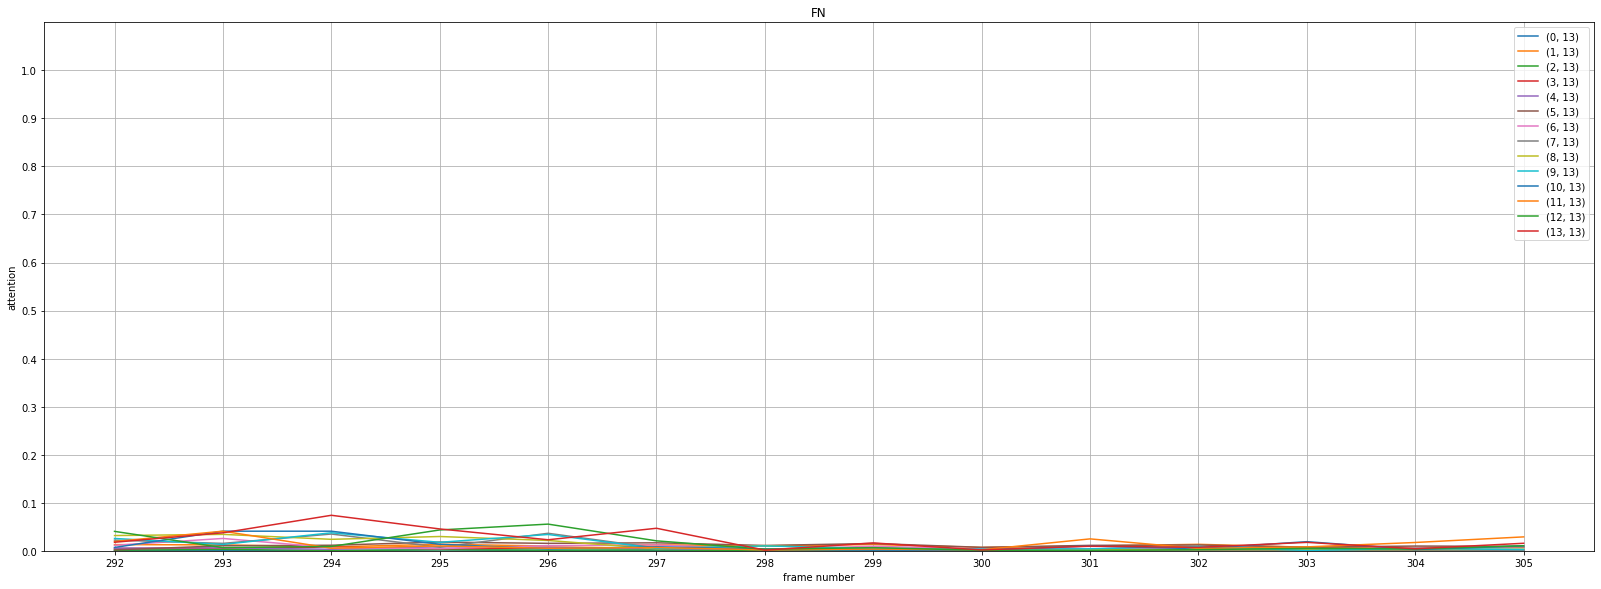

In [154]:
i = 13

# attention_list_TP, data_number_list_TP = draw_img_TP(model=model, PATH_data_list=PATH_sample_data_TP_list, label='TP')
# plot_attention_range(attention_list=attention_list_TP, patch_index=patch_index[i], data_number_list=data_number_list_TP, label='TP', save_file_name='output/TP/'+str(i)+'.jpg')
# del attention_list_TP, data_number_list_TP
# gc.collect()

# attention_list_TN, data_number_list_TN = draw_img_TN(model=model, PATH_data_list=PATH_sample_data_TN_list, label='TN')
# plot_attention_range(attention_list=attention_list_TN, patch_index=patch_index[i], data_number_list=data_number_list_TN, label='TN', save_file_name='output/TN/'+str(i)+'.jpg')

# attention_list_FP, data_number_list_FP = draw_img_FP(model=model, PATH_data_list=PATH_sample_data_FP_list, label='FP')
# plot_attention_range(attention_list=attention_list_FP, patch_index=patch_index[i], data_number_list=data_number_list_FP, label='FP', save_file_name='output/FP/'+str(i)+'.jpg')

attention_list_FN, data_number_list_FN = draw_img_FN(model=model, PATH_data_list=PATH_sample_data_FN_list, label='FN')
plot_attention_range(attention_list=attention_list_FN, patch_index=patch_index[i], data_number_list=data_number_list_FN, label='FN', save_file_name='output/FN/'+str(i)+'.jpg')
    